# Hand Measurements

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imutils import grab_contours
import imutils
import pandas as pd


class Hand_measurement:
    """
    A class to include all hand measurement related functions.

    ...

    Attributes
    ----------
    image : str
        Name of image which hand measurements should be taken on
    side : str
        Side of the hand in image (Left or Right. Not case sensitive)
    th_low : int
        Lower threshold limit
    th_up : int
        Upper threshold limit

    Methods
    -------
    ppm_to_metric(array1,array2):
        Calculates the distance in metric units between two arrays.
    threshold():
        Converts given image to gray, filters and thresholds it, applies morphological transforms.
    contours():
        Finds contours in thresholded image. Also find contour of hand and its convex hull and convexity defects.
    finger_tips_calculation():
        Calculates location of the finger tips, center of hand contour and inner point between thumb(1) and index finger(2)
    finger_tips():
        Draws circles to the finger tips of the image. Also labels them according to the side of hand.
    reference_measurement():
        Finds Euro Coin in contours, calculates its radius. Divides radius(in pixels) to reference metric unit to find pixels per metric value.
    hand_length():
        Finds reference point in wrist. Returns distance between this point to fingertip of middle finger(2) in metric units
    hand_width():
        Finds reference point in opposite side of the inner point between thumb(1) and index finger(2). Returns distance between this point to inner point in metric units.
    one_to_three():
        Returns distance between thumb (1) to middle finger(3) in metric units.
    five_to_three():
        Returns distance between little finger(5) to middle finger(3) in metric units.

    """

    def __init__(self, image, side, th_low=29, th_up=255):
        """
        Constructs all the necessary attributes for the Hand_measurement object.

        Args:
            image (str): Name of image which hand measurements should be taken on
            side (str): Side of the hand in image (Left or Right. Not case sensitive)
            th_low (int, optional): Lower threshold limit. Defaults to 29.
            th_up (int, optional): Upper threshold limit. Defaults to 255.
        """
        self.side = side
        self.image = cv2.imread(image)
        self.threshold_upper = th_up
        self.threshold_lower = th_low

        self.contours, self.hand, self.defects = self.contours()
        self.fingers, self.palm_side, self.center = self.finger_tips_calculation()
        self.ppm = self.reference_measurement()

    def ppm_to_metric(self, array1, array2):
        """
        Calculates the distance in metric units between two arrays (Point A - Point B).

        Args:
            array1 (tuple): Point A
            array2 (tuple): Point B

        Returns:
            numpy.float64: Distance in metric units
        """
        # Reference on using np.linalg.norm to find euclidean distance:
        # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
        in_pixels = np.linalg.norm(np.array(array1) - np.array(array2))
        return in_pixels / self.ppm

    def threshold(self):
        """
        Converts given image to gray. Applies bilateralFilter and thresholds it. Threshold values are customizable in class instance.
        After thresholding applies Dilation(itr=1) and Erosion(itr=2)

        Returns:
            numpy.ndarray: Array of the image with transformations applied
        """
        image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bilateralFilter(image, d=17, sigmaSpace=185, sigmaColor=185)
        _, thresh = cv2.threshold(gray, self.threshold_lower, self.threshold_upper, cv2.THRESH_BINARY)
        kernel = np.ones((24, 24), np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        edged = cv2.dilate(thresh, None, iterations=1)
        edged = cv2.erode(edged, None, iterations=2)
        return edged

    def contours(self):
        """
        Finds contours in thresholded image. Finds the maximum contour by area and identifies it as contour of hand.
        Afterwards, find convexhull and convexitydefects of this contour(hand)

        Returns:
            list: List of contours
            numpy.ndarray: Convexhull of the hand
            numpy.ndarray: Convexity defects of the hand
        """
        cnts = cv2.findContours(self.threshold(), cv2.cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = grab_contours(cnts)

        hand = max(cnts, key=cv2.contourArea)
        hull = cv2.convexHull(hand, returnPoints=False)
        defects = cv2.convexityDefects(hand, hull)
        return cnts, hand, defects

    def finger_tips_calculation(self):
        """
        Filters convexity defects by appling Cosine Theorem; calculates the angle theta for each defect,
        if the angle theta is less than π/2, defects are appended to seperate lists. The seperate lists can be used to identify:

        Right Hand:

        Start[0] = Thumb (1)
        Start[1] = Index (2)
        Start[2] = Middle (3)
        Start[3] = Ring (4)
        End[3]  = Little  (5)
        Far[0] = Point between thumb and side of palm

        Left Hand:

        Start[0] = Little (5)
        Start[1] = Ring (4)
        Start[2] = Middle (3)
        Start[3] = Index (2)
        End[3] = Thumb (1)
        Far[3] = Point between thumb and side of palm

        Also finds center of the hand contour by using cv2.moments method.

        Returns:
            list: Startlist containing 4 of the finger tips depending on side of hand
            list: Endlist Containing remaining finger tips depending on side of hand
            list: Center of the contour
        """
        M = cv2.moments(self.hand)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        endlist = []
        startlist = []
        farlist = []

        for i in range(self.defects.shape[0]):
            s, e, f, d = self.defects[i, 0]
            start = tuple(self.hand[s][0])
            end = tuple(self.hand[e][0])
            far = tuple(self.hand[f][0])

            # Cosine Theorem more information at:
            # https://medium.com/analytics-vidhya/hand-detection-and-finger-counting-using-opencv-python-5b594704eb08

            a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
            b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
            c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)

            angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))

            if angle <= np.pi / 2:
                startlist.append(start)
                endlist.append(end)
                farlist.append(far)
        startlist.append(endlist[3])
        return startlist, farlist, [cx, cy]

    def finger_tips(self):
        """
        Draws circles to the finger tips of the image. Also labels them according to the side of hand.

        """

        count = 0
        if self.side.lower() == "left":
            for i in self.fingers:
                cv2.circle(self.image, tuple(i), 16, [0, 0, 255], -1)
                count += 1
                cv2.putText(self.image, str(count), tuple(i), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2,
                            cv2.LINE_AA)

        if self.side.lower() == "right":
            for i in self.fingers[::-1]:
                cv2.circle(self.image, tuple(i), 16, [0, 0, 255], -1)
                count += 1
                cv2.putText(self.image, str(count), tuple(i), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2,
                            cv2.LINE_AA)

    def reference_measurement(self):
        """
        Sorts the contours according to the contour area. Finds the enclosing circle of the smallest contour (1 Euro Coin) using OpenCV method,
        which returns center coordinates of this circle and radius.As diameter of 1 Euro Coin is known,(Diameter of 1 Euro Coin :  23.25mm)

        Radius can be multiplied by two to find diameter. Afterwards, diameter in pixels can be divided in to reference metric value to find pixels per metric value for image.

        Returns:
            float: Pixel Per Metric value
        """

        ref = []

        for c in self.contours:
            if cv2.contourArea(c) < int(self.image.shape[1]*0.03*self.image.shape[0]*0.03) or cv2.contourArea(c) == cv2.contourArea(self.hand):
                continue
            ref.append(c)


        (x, y), r = cv2.minEnclosingCircle(ref[0])
        center = (int(x), int(y))
        radius = int(r)
        diameter = radius * 2
        # cv2.circle(self.image, tuple(center), radius, [0, 0, 255], -1)
        # Diameter of 1 Euro Coin :  23.25mm
        # Diameter of 2 Euro Coin :  25.75mm
        ppM = diameter / 2.32500
        return ppM

    def hand_length(self):
        """
        Finds reference point in wrist: As the coordinates of the center is known, and the highest point of the contour can be find easily.
        By combining X coordinate of the center and Y coordinate of the highest point of contour reference point in wrist can be found.
        Then, this reference value can be subtracted from middle finger (3) tip  using ppm_to_metric method which returns distance in centimeters.
        Also draws arrowedlines and adds text for visualization.

        Returns:
            float: Distance between reference point in wrist to middle finger (3) tip in metric units.
        """
        extTop = tuple(self.hand[self.hand[:, :, 1].argmin()][0])
        bottom = [self.center[0], extTop[1]]

        cv2.arrowedLine(self.image, tuple(bottom), self.fingers[2], (105, 237, 249), 8, tipLength=0.05)
        cv2.arrowedLine(self.image, self.fingers[2], tuple(bottom), (105, 237, 249), 8, tipLength=0.05)

        lengthpixels = np.linalg.norm(np.array(extTop) - np.array(self.fingers[2]))
        distance = self.ppm_to_metric(extTop, self.fingers[2])

        cv2.putText(self.image, str(str(round(distance, 2)) + " cm"),
                    tuple((int(self.fingers[2][0] * 1.05), self.fingers[2][1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 2.4, (255, 255, 255), 4, cv2.LINE_AA)

        return abs(lengthpixels / self.ppm)

    def hand_width(self):
        """
        Returns the width of the hand by finding second measurement point in side of the palm and calculating the distance between two reference points.

        Finds second reference in other side of the palm by: (If side = left, calculated reference point will be on right and vice versa.)

        Left Hand: (First reference point is = Far [3], point between thumb and side of palm)
                • Destructures the hand contour and appends the contours where the Y coordinate of contour is between 95% and %110 of first reference point.
                • Finds X coordinate of smallest pair in terms of X coordinate. Y value is the Y value of the first reference point

        Right Hand: (First reference point is = Far [0], point between thumb and side of palm)
            • Destructures the hand contour and appends the contours where the Y coordinate of contour is between 95% and %110 of first reference point.
            • Finds X coordinate of smallest pair in terms of X coordinate. Y value is the Y value of the first reference point

        Returns:
            float: Distance between two reference points (hand width) in terms of metric values
        """

        if self.side.lower() == "left":
            side = []
            for c in self.hand:
                for n in c:
                    if n[1] >= int(self.palm_side[3][1] * 0.95) and n[1] <= int(self.palm_side[3][1] * 1.05):
                        if not n[0] > int(self.palm_side[3][0]):
                            side.append(c)

            side_ref = tuple((side[0][0][0], self.palm_side[3][1]))
            cv2.arrowedLine(self.image, side_ref, self.palm_side[3], (211, 234, 0), 8, tipLength=0.1)
            cv2.arrowedLine(self.image, self.palm_side[3], side_ref, (211, 234, 0), 8, tipLength=0.1)
            distance = self.ppm_to_metric(self.palm_side[3], side_ref)
            cv2.putText(self.image, str(str(round(distance, 2)) + " cm"),
                        tuple((int(self.center[0] * 0.5), int(self.center[1] * 0.97))), cv2.FONT_HERSHEY_SIMPLEX, 2.4,
                        (255, 255, 255),
                        5, cv2.LINE_AA)
            return distance

        if self.side.lower() == "right":
            side = []

            for c in self.hand:
                for n in c:
                    if n[1] >= int(self.palm_side[0][1] * 0.95) and n[1] <= int(self.palm_side[0][1] * 1.05):
                        if not n[0] < int(self.palm_side[0][0]):
                            side.append(c)
            side = side[::-1]
            side_ref = tuple((side[0][0][0], self.palm_side[0][1]))
            cv2.arrowedLine(self.image, side_ref, self.palm_side[0], (211, 234, 0), 8, tipLength=0.1)
            cv2.arrowedLine(self.image, self.palm_side[0], side_ref, (211, 234, 0), 8, tipLength=0.1)
            distance = self.ppm_to_metric(self.palm_side[0], side_ref)
            cv2.putText(self.image, str(str(round(distance, 2)) + " cm"),
                        tuple((int(self.center[0]), int(self.center[1] * 0.97))), cv2.FONT_HERSHEY_SIMPLEX, 2.4,
                        (255, 255, 255),
                        5, cv2.LINE_AA)
            return distance

    def one_to_three(self):
        """
        Returns the distance between thumb (1) and middle finger (3). The top corner of the smallest enclosing rectangle is given by:
            (X Value of Thumb (1) finger tip , Y Value of Middle (3) finger tip)

        By subtracting this point from the Thumb (1) finger tip, using the ppm_to_metric method distance in metric values will be calculated.

        (For Left Hand Finger tip of thumb (1) is given by : End[3])
        (For Right Hand Finger tip of thumb (1) is given by : Start[0])

        Returns:
            float: Distance between Thumb (1) finger tip and Middle (3) finger tip
        """
        if self.side.lower() == "left":
            k = 4
        if self.side.lower() == "right":
            k = 0

        top_corner = (self.fingers[k][0], self.fingers[2][1])

        cv2.arrowedLine(self.image, tuple(top_corner), self.fingers[k], (203, 169, 57), 8, tipLength=0.05)
        cv2.arrowedLine(self.image, self.fingers[k], tuple(top_corner), (203, 169, 57), 8, tipLength=0.05)

        distance = self.ppm_to_metric(top_corner, self.fingers[k])

        cv2.putText(self.image, str(str(round(distance, 2)) + " cm"),
                    tuple((top_corner[0], int(top_corner[1] * 0.8))), cv2.FONT_HERSHEY_SIMPLEX, 2.4, (255, 255, 255),
                    5, cv2.LINE_AA)

        return distance

    def five_to_three(self):
        """
        Returns the distance between :ittle (5) finger and middle finger (3). The top corner of the smallest enclosing rectangle is given by:
        (X Value of Little (5) finger tip , Y Value of Middle (3) finger tip)

        By subtracting this point from the Thumb (1) finger tip, using the ppm_to_metric method distance in metric values will be calculated.

        (For Left Hand Finger tip of Little (1) finger is given by : Start[0])
        (For Right Hand Finger tip of Little  (1) finger is given by : End[3])

        Returns:
            float: Distance between Little (5) finger tip and Middle (3) finger tip
        """
        if self.side.lower() == "left":
            k = 0
        if self.side.lower() == "right":
            k = 4
        top_corner = (self.fingers[k][0], self.fingers[2][1])

        cv2.arrowedLine(self.image, tuple(top_corner), self.fingers[k], (203, 169, 57), 8, tipLength=0.1)
        cv2.arrowedLine(self.image, self.fingers[k], tuple(top_corner), (203, 169, 57), 8, tipLength=0.1)

        distance = self.ppm_to_metric(top_corner, self.fingers[k])

        cv2.putText(self.image, str(str(round(distance, 2)) + " cm"),
                    tuple((top_corner[0], int(top_corner[1] * 0.97))), cv2.FONT_HERSHEY_SIMPLEX, 2.4, (255, 255, 255),
                    5, cv2.LINE_AA)

        return distance

    def plot_table(self):
        """
        Applies previous methods to the image, and creates a table with these values.
        """
        self.finger_tips()
        a = str(str(round(self.hand_width(), 2)) + " cm")
        b = str(str(round(self.hand_length(), 2)) + " cm")
        c = str(str(round(self.one_to_three(), 2)) + " cm")
        d = str(str(round(self.five_to_three(), 2)) + " cm")

        df = {"Width": [a], "Length": [b], "3-5 Difference": [c], "1-3 Difference": [d]}
        x = pd.DataFrame.from_dict(df)
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))

        the_table = plt.table(cellText=x.values,
                              rowLoc='right',
                              colLabels=x.columns,
                              #                               cellColours=["#00ead3","#38a6c8","#f2e666","#38a6c8"],

                              loc='bottom')

        plt.subplots_adjust(left=0.2, bottom=0.18)

        the_table.scale(2, 2)
        the_table[(1, 0)].set_facecolor("#00ead3")
        the_table[(1, 1)].set_facecolor("#f2e666")
        the_table[(1, 2)].set_facecolor("#38a6c8")
        the_table[(1, 3)].set_facecolor("#38a6c8")
        the_table[(0, 0)].set_facecolor("#00ead3")
        the_table[(0, 1)].set_facecolor("#f2e666")
        the_table[(0, 2)].set_facecolor("#38a6c8")
        the_table[(0, 3)].set_facecolor("#38a6c8")
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)

        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.box(on=None)
        plt.suptitle("Hand Measurements")

        plt.draw()
        plt.show()

        return


## Some Examples

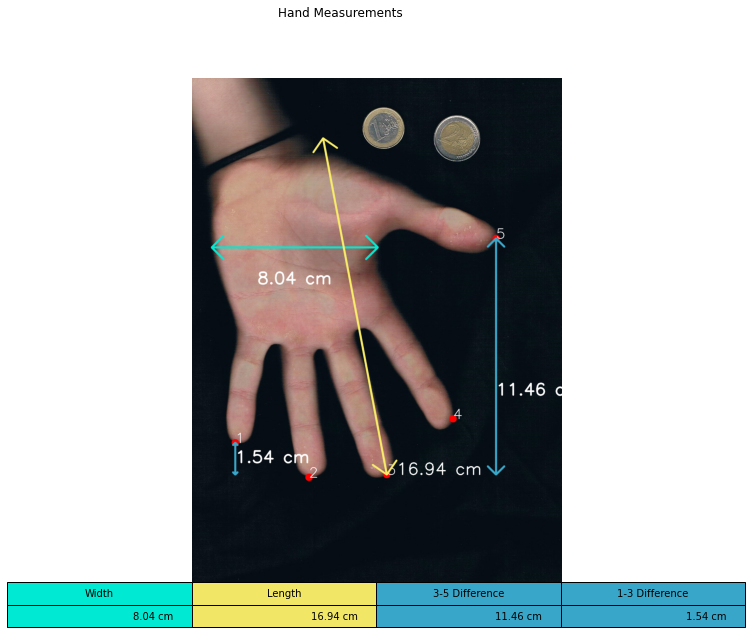

In [29]:
hand = Hand_measurement("Image (13).jpg", "left")
plt.figure(figsize=(10,10)) 
hand.plot_table()

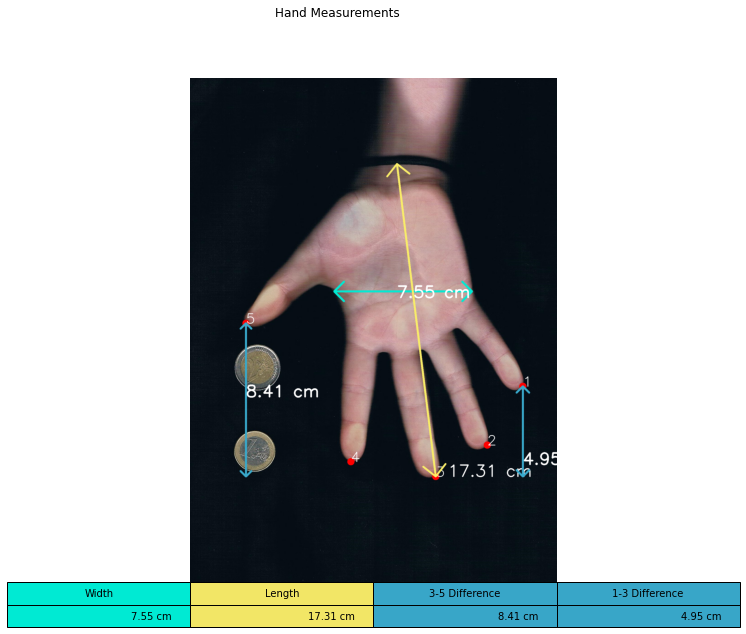

In [36]:
hand = Hand_measurement("Image (2).jpg", "right")
plt.figure(figsize=(10,10)) 
hand.plot_table()

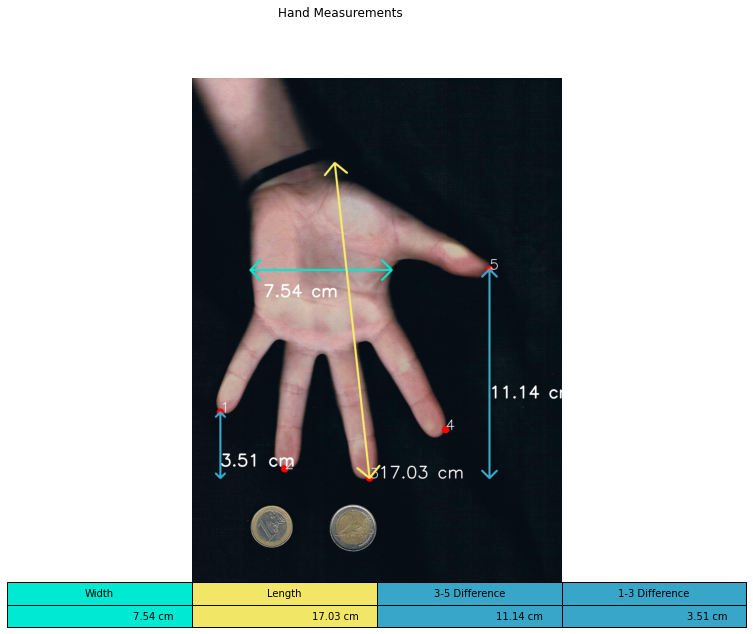

In [35]:
hand = Hand_measurement("Image (16).jpg", "left")
plt.figure(figsize=(10,10)) 
hand.plot_table()

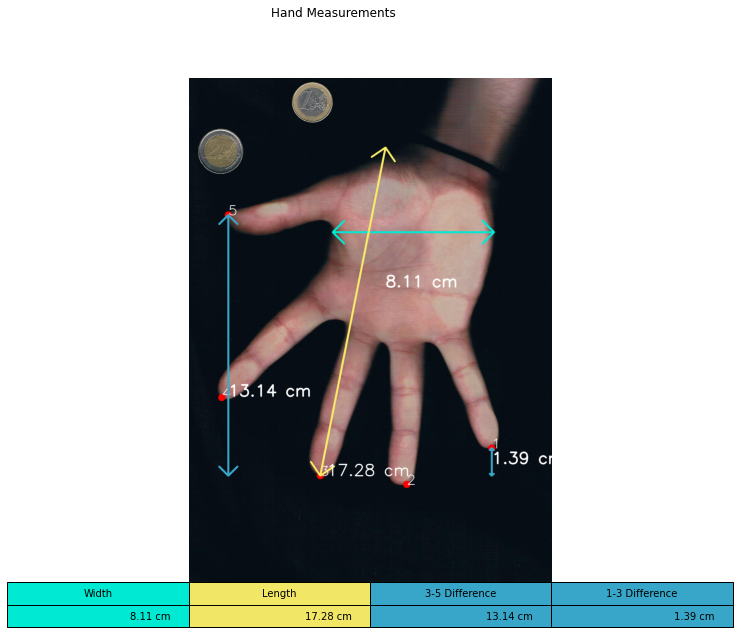

In [30]:
hand = Hand_measurement("Image (9).jpg", "right")
plt.figure(figsize=(10,10)) 
hand.plot_table()

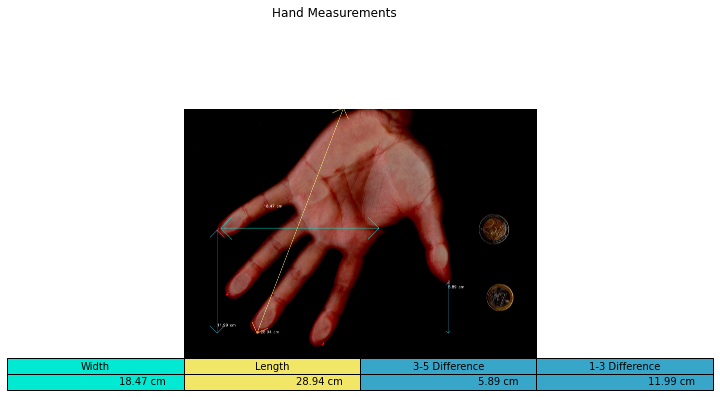

In [33]:
newhand = Hand_measurement("SCAN20210310_0013.png", "left",14,255)
plt.figure(figsize=(7,7))
newhand.plot_table()

In the figure above, as the hand is rotated second reference point to calculate the hand width couldn't be found correctly.

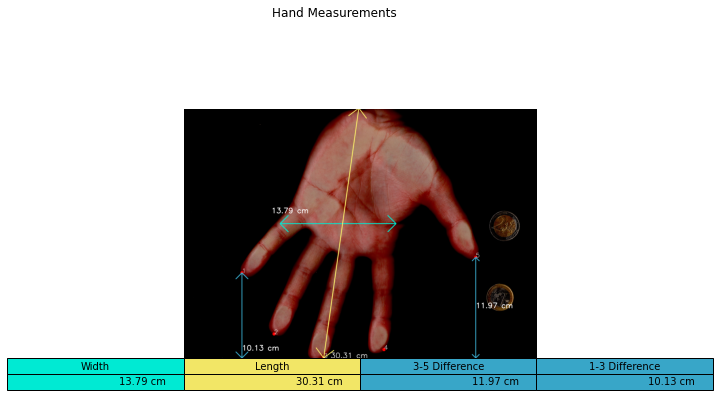

In [34]:
newhand = Hand_measurement("SCAN20210310_0014.bmp", "left",14,255)
plt.figure(figsize=(7,7))
newhand.plot_table()

## Some recommendations and requirements about application

While using the application in order to get the most reliable and accurate results it is important to scan the hand as vertical as possible. 

The hand scan should be taken:

- Over dark cloth
- Alongside 1 Euro coin
- With black band on wrist



Also another requirement of this application is that the fingers has to be facing downwards the image.

